In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold,cross_val_score
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_recall_curve,auc,roc_auc_score,recall_score,classification_report
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
from sklearn import svm
import random

W:\anaconda_python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
random_seed = 72
random.seed(random_seed)
np.random.seed(random_seed)

df = pd.read_csv("../dataset/aps_failure_training_set.csv")
df_test = pd.read_csv("../dataset/aps_failure_test_set.csv")

In [4]:
df.head()


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
df = df.rename(columns = {'class' : 'Flag'})
df['Flag'] = df.Flag.map({'neg':0, 'pos':1})
df = df.replace(['na'],[np.NaN])

In [6]:
df.isnull().any()


Flag      False
aa_000    False
ab_000     True
ac_000     True
ad_000     True
ae_000     True
af_000     True
ag_000     True
ag_001     True
ag_002     True
ag_003     True
ag_004     True
ag_005     True
ag_006     True
ag_007     True
ag_008     True
ag_009     True
ah_000     True
ai_000     True
aj_000     True
ak_000     True
al_000     True
am_0       True
an_000     True
ao_000     True
ap_000     True
aq_000     True
ar_000     True
as_000     True
at_000     True
          ...  
dl_000     True
dm_000     True
dn_000     True
do_000     True
dp_000     True
dq_000     True
dr_000     True
ds_000     True
dt_000     True
du_000     True
dv_000     True
dx_000     True
dy_000     True
dz_000     True
ea_000     True
eb_000     True
ec_00      True
ed_000     True
ee_000     True
ee_001     True
ee_002     True
ee_003     True
ee_004     True
ee_005     True
ee_006     True
ee_007     True
ee_008     True
ee_009     True
ef_000     True
eg_000     True
Length: 171, dtype: bool

Text(0,0.5,'Frequency')

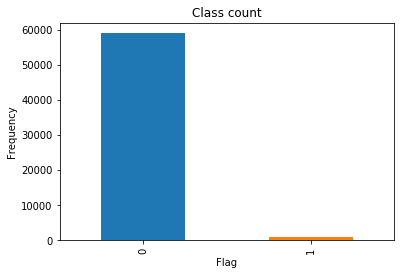

In [7]:
Count = pd.value_counts(df['Flag'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Class count")
plt.xlabel("Flag")
plt.ylabel("Frequency")

In [8]:
df_X = df.loc[:,df.columns != 'Flag']
df_Y = df.loc[:,df.columns == 'Flag']

df_X = df_X.apply(pd.to_numeric)

df_X= df_X.fillna(df_X.mean()).dropna(axis =1 , how ='all')

scaler = StandardScaler()

scaler.fit(df_X)

df_X = scaler.transform(df_X)

pca = PCA(0.95)

pca.fit(df_X)

pca.n_components_

82

In [9]:
df_X = pca.transform(df_X)

df_X= pd.DataFrame(df_X)

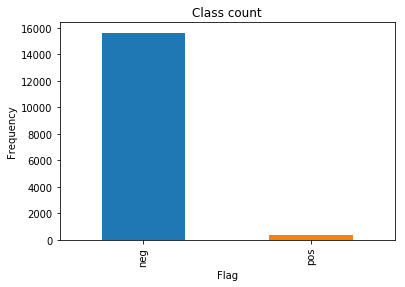

In [10]:
df_test = df_test.rename(columns = {'class' : 'Flag'})
df_test = df_test.replace(['na'],[np.NaN])

Count = pd.value_counts(df_test['Flag'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Class count")
plt.xlabel("Flag")
plt.ylabel("Frequency")

df_test['Flag'] = df_test.Flag.map({'neg':0, 'pos':1})

df_test_X = df_test.loc[:,df_test.columns != 'Flag']
df_test_Y = df_test.loc[:,df_test.columns == 'Flag']

df_test_X = df_test_X.apply(pd.to_numeric)

df_test_X= df_test_X.fillna(df_test_X.mean()).dropna(axis =1 , how ='all')

scaler = StandardScaler()

scaler.fit(df_test_X)

df_test_X = scaler.transform(df_test_X)

pca = PCA(82)

pca.fit(df_test_X)

pca.n_components_

df_test_X = pca.transform(df_test_X)

df_test_X= pd.DataFrame(df_test_X)

In [11]:
X_train,X_validation,Y_train,Y_validation = train_test_split(df_X,df_Y,test_size = 0.2,random_state = 0)
DF = pd.concat([X_train,Y_train],axis = 1)

print("Percentage Neg in training: " , len(Y_train[Y_train.Flag == 0])/len(Y_train))
print("Percentage Pos in training: ", len(Y_train[Y_train.Flag == 1])/len(Y_train))
print("Total number of datapoints in training: ", len(Y_train))


print("Percentage Neg in Validation: " , len(Y_validation[Y_validation.Flag == 0])/len(Y_validation))
print("Percentage Pos in Validation: ", len(Y_validation[Y_validation.Flag == 1])/len(Y_validation))
print("Total number of datapoints in Validation: ", len(Y_validation))

Percentage Neg in training:  0.983
Percentage Pos in training:  0.017
Total number of datapoints in training:  48000
Percentage Neg in Validation:  0.9846666666666667
Percentage Pos in Validation:  0.015333333333333332
Total number of datapoints in Validation:  12000


In [12]:
numberofrecords_pos = len(DF[DF.Flag == 1])
pos_indices = np.array(DF[DF.Flag == 1].index)

#Picking the indices of the normal class
neg_indices = DF[DF.Flag == 0].index

#out of indices selected, randomly select "x" number of records
random_neg_indices = np.random.choice(neg_indices, numberofrecords_pos, replace = False)
random_neg_indices =np.array(random_neg_indices)

#Appending the two indices
under_sample_indices = np.concatenate([pos_indices,random_neg_indices])

#Undersample dataset
under_sample_data = DF.loc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:,under_sample_data.columns != 'Flag']
Y_undersample = under_sample_data.loc[:,under_sample_data.columns == 'Flag']

print("Percentage Neg: " , len(under_sample_data[under_sample_data.Flag == 0])/len(under_sample_data))
print("Percentage Pos : ", len(under_sample_data[under_sample_data.Flag == 1])/len(under_sample_data))
print("Total number of datapoints : ", len(under_sample_data))

Percentage Neg:  0.5
Percentage Pos :  0.5
Total number of datapoints :  1632


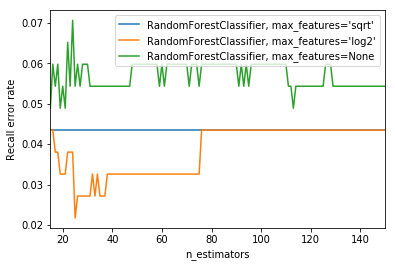

In [13]:
RANDOM_STATE = 123

import warnings
warnings.filterwarnings("ignore")
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_undersample, Y_undersample)

        # Record the OOB error for each `n_estimators=i` setting.
        y_pred = clf.predict(X_validation)
        recall = recall_score(Y_validation,y_pred)
        error = 1 - recall
        error_rate[label].append((i, error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Recall error rate")
plt.legend(loc="upper right")
plt.show()

In [14]:
clf = RandomForestClassifier(n_estimators=25,max_features= 'log2',oob_score =True)

clf.fit(X_undersample,Y_undersample.values.ravel())

clf.oob_score_

y_pred = clf.predict(df_test_X)
recall_score(df_test_Y,y_pred)

0.9733333333333334

In [15]:
confusion_matrix(df_test_Y,y_pred)


array([[13843,  1782],
       [   10,   365]], dtype=int64)